In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
%config InlineBackend.figure_format = 'retina'

np.random.seed(7)

In [2]:
dataframe = pd.read_csv('../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

dataset = dataframe.values
dataset = dataset.astype('float32')

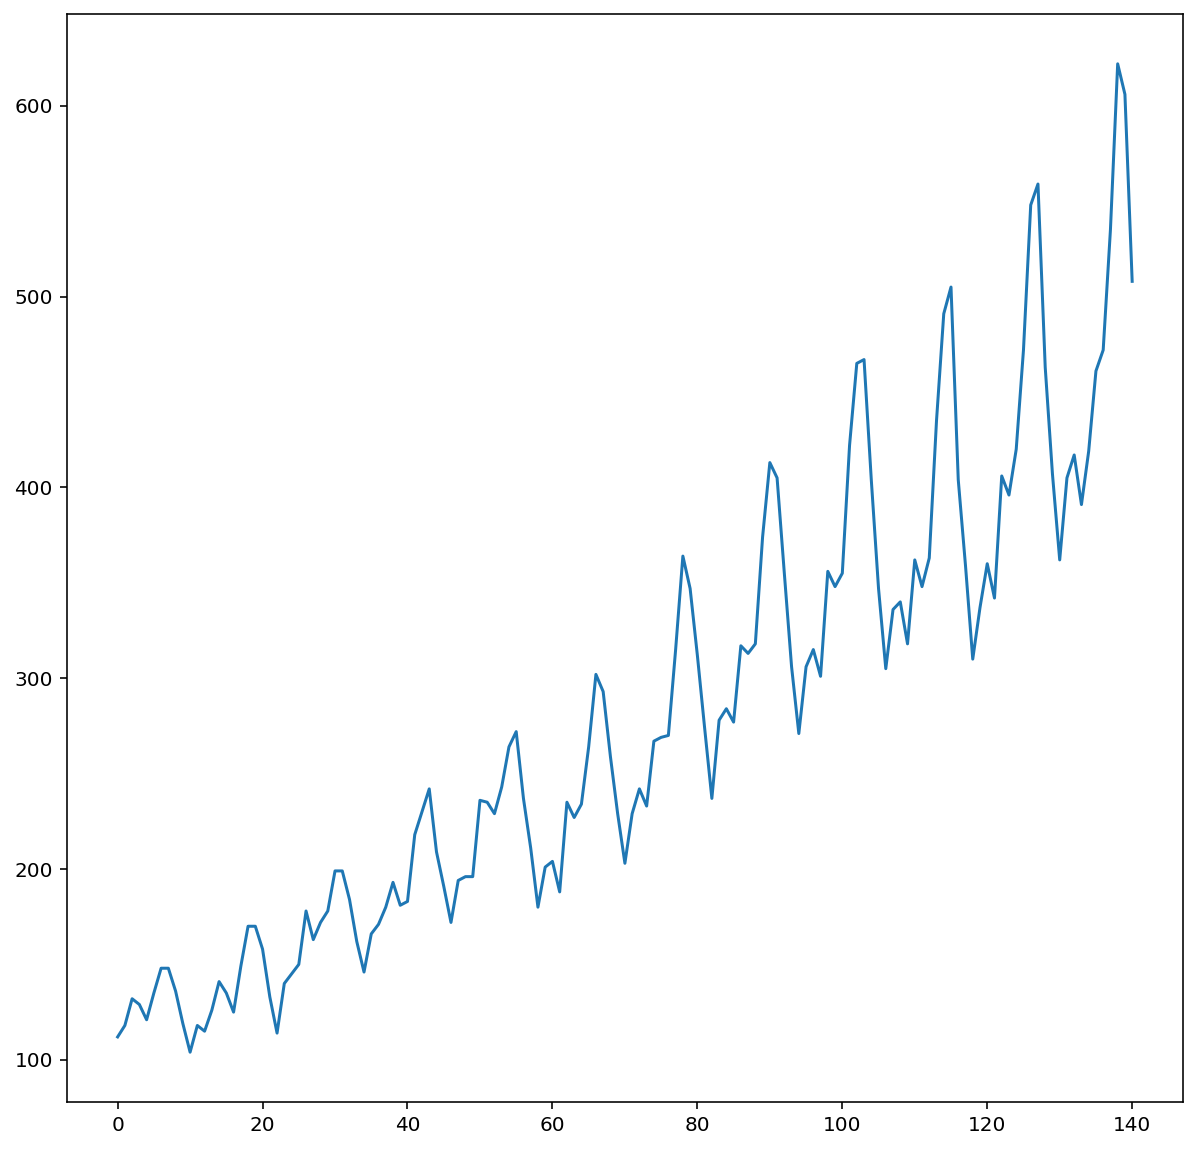

In [3]:
plt.plot(dataset)
plt.show()

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
model = Sequential()
model.add(LSTM(4, input_dim = look_back))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam' )
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 - 1s - loss: 0.0360 - 1s/epoch - 11ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0168 - 93ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0132 - 89ms/epoch - 963us/step
Epoch 4/100
92/92 - 0s - loss: 0.0122 - 89ms/epoch - 965us/step
Epoch 5/100
92/92 - 0s - loss: 0.0114 - 91ms/epoch - 987us/step
Epoch 6/100
92/92 - 0s - loss: 0.0107 - 90ms/epoch - 983us/step
Epoch 7/100
92/92 - 0s - loss: 0.0098 - 91ms/epoch - 989us/step
Epoch 8/100
92/92 - 0s - loss: 0.0087 - 100ms/epoch - 1ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0078 - 95ms/epoch - 1ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0068 - 90ms/epoch - 982us/step
Epoch 11/100
92/92 - 0s - loss: 0.0059 - 90ms/epoch - 97

In [7]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print("Train Score: %.2f MSE (%.2f RMSE)" % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print("Test Score:  %.2f MSE (%.2f RMSE)" % (testScore, math.sqrt(testScore)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train Score: 0.00 MSE (0.04 RMSE)
Test Score:  0.01 MSE (0.10 RMSE)


In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 0s 2ms/step


In [9]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Train Score: %.2f RMSE" % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 23.30 RMSE
Test Score: 50.00 RMSE


In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

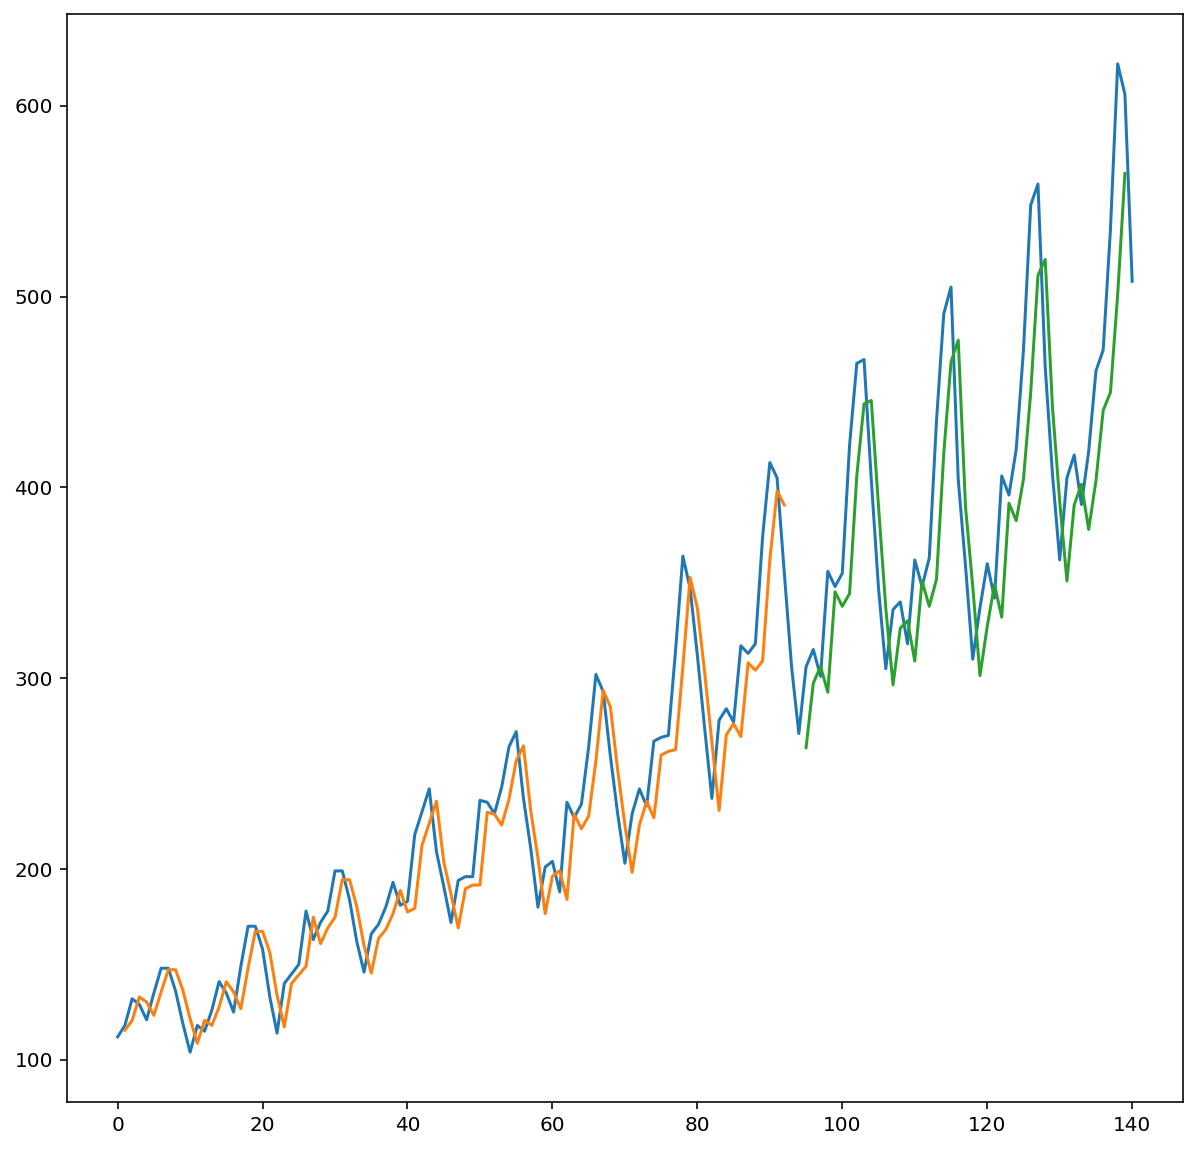

In [12]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()